# Spark ML для задачи оттока

Источник данных: [Kaggle](https://www.kaggle.com/sakshigoyal7/credit-card-customers)

Описания полей:

 | Название        | Описание                                                                                                                            |
 |:----------------|:------------------------------------------------------------------------------------------------------------------------------------|
 | CLIENTNUM       | Client number. Unique identifier for the customer holding the account                                                               |
 | Attrition_Flag  | Internal event (customer activity) variable                                                                                         |
 | Customer_Age    | Demographic variable - Customer's Age in Years                                                                                      |
 | Gender          | Demographic variable - M=Male, F=Female                                                                                             |
 | Dependent_count | Demographic variable - Number of dependents                                                                                         |
 | Education_Level | Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)               |
 | Marital_Status  | Demographic variable - Married, Single, Divorced, Unknown                                                                           |
 | Income_Category | Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, > $120K, Unknown) |
 | Card_Category   | Product Variable - Type of Card (Blue, Silver, Gold, Platinum)                                                                      |
 | Months_on_book  | Period of relationship with bank                                                                                                    |

In [23]:
!pip install findspark

Defaulting to user installation because normal site-packages is not writeable


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f 

spark = SparkSession\
    .builder\
    .master("local[*]")\
    .appName("Spark ML Research")\
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
import pyspark
pyspark.__version__

'3.3.2'

## Загрузка и знакомство с данными

In [5]:
df = spark.read.csv("data/BankChurners.csv", header=True, inferSchema=True)

### Убираем первую и последние две колонки

In [6]:
columns = df.columns
columnsLen = len(columns)
colsToDrop = columns[0].split() + columns[columnsLen-2:columnsLen]

df = df.drop(*colsToDrop)

df.limit(5)

Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.0
Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.76
Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.5,0.0


### Определяем типы колонок

In [30]:
df.printSchema()

root
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (nullable = true)



In [31]:
dt = df.dtypes

for r in dt:
    print(f"{r[0]:>25}\t{r[1]}")

           Attrition_Flag	string
             Customer_Age	int
                   Gender	string
          Dependent_count	int
          Education_Level	string
           Marital_Status	string
          Income_Category	string
            Card_Category	string
           Months_on_book	int
 Total_Relationship_Count	int
   Months_Inactive_12_mon	int
    Contacts_Count_12_mon	int
             Credit_Limit	double
      Total_Revolving_Bal	int
          Avg_Open_To_Buy	double
     Total_Amt_Chng_Q4_Q1	double
          Total_Trans_Amt	int
           Total_Trans_Ct	int
      Total_Ct_Chng_Q4_Q1	double
    Avg_Utilization_Ratio	double


In [32]:
from itertools import groupby

dt.sort(key=lambda x: x[1])

for k, g in groupby(dt, lambda x: x[1]):
    print(k, len(list(g)))

double 5
int 9
string 6


### Проверим числовые колонки

In [33]:
numericColumns = list(
    map(
        lambda x: x[0], 
        filter(lambda x: x[1] == "double" or x[1] == "int", df.dtypes)
    )
)
numericColumns

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [34]:
df.select(*numericColumns).summary()

summary,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127
mean,46.32596030413745,2.3462032191172115,35.928409203120374,3.8125802310654686,2.3411671768539546,2.4553174681544387,8631.953698034848,1162.8140614199665,7469.139636614887,0.7599406536980376,4404.086303939963,64.85869457884863,0.7122223758269962,0.2748935518909845
stddev,8.016814032549046,1.29890834890379,7.98641633087208,1.55440786533883,1.0106223994182844,1.1062251426359249,9088.776650223148,814.9873352357533,9090.685323679114,0.2192067692307027,3397.129253557085,23.47257044923301,0.23808609133294137,0.27569146925238736
min,26,0,13,1,0,0,1438.3,0,3.0,0.0,510,10,0.0,0.0
25%,41,1,31,3,2,2,2555.0,357,1322.0,0.631,2155,45,0.581,0.022
50%,46,2,36,4,2,2,4549.0,1276,3472.0,0.736,3899,67,0.702,0.175
75%,52,3,40,5,3,3,11067.0,1784,9857.0,0.859,4741,81,0.818,0.503
max,73,5,56,6,6,6,34516.0,2517,34516.0,3.397,18484,139,3.714,0.999


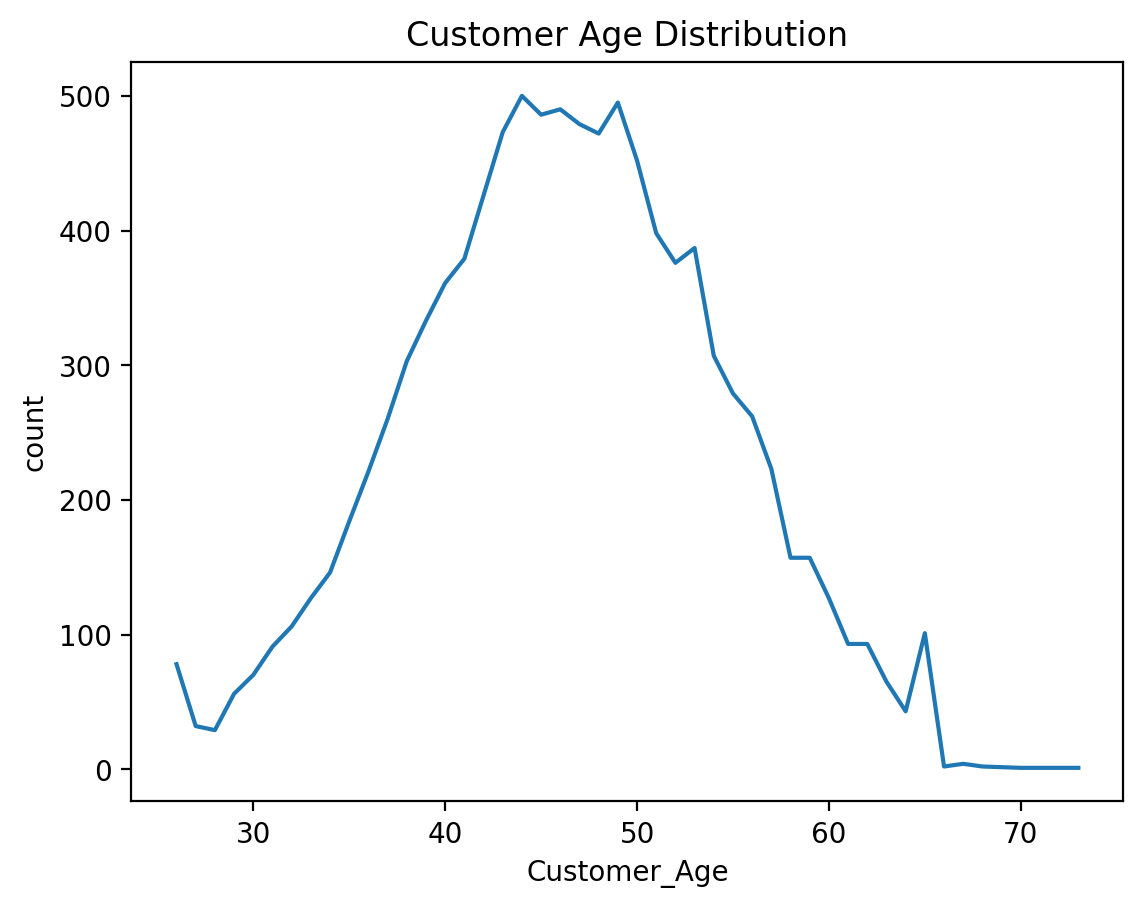

In [35]:
import matplotlib.pyplot as plt

age = df.groupBy("Customer_Age").count().orderBy("Customer_Age")
x_val = [val["Customer_Age"] for val in age.select("Customer_Age").collect()]
y_val = [val["count"] for val in age.select("count").collect()]

plt.plot(x_val, y_val)

plt.xlabel("Customer_Age")
plt.ylabel("count")
plt.title("Customer Age Distribution")

plt.show()

## Создадим колонку с целевая переменной

In [36]:
dft = df.withColumn(
    "target", 
    f.when(df["Attrition_Flag"] == "Existing Customer", 0).otherwise(1)
)

dft.select("Attrition_Flag", "target").limit(5)

Attrition_Flag,target
Existing Customer,0
Existing Customer,0
Existing Customer,0
Existing Customer,0
Existing Customer,0


### Проверка сбалансированности данных

In [38]:
dft.groupBy("target").count()

target,count
1,1627
0,8500


### Oversampling

In [39]:
df1 = dft.filter(dft["target"] == 1)
df0 = dft.filter(dft["target"] == 0)

df1count = df1.count()
df0count = df0.count()

trate = int(df0count / df1count)
trate

5

### Как работает explode

In [41]:
test_df = spark.createDataFrame(
    [
        ['Peter',  ['python', 'C/C++', 'rust', 'golang']],
        ['Eugene', ['java', 'scala', 'kotlin']]
    ],
    ['Name', 'Languages']
)

test_df.toPandas()

,Name,Languages
0,Peter,"[python, C/C++, rust, golang]"
1,Eugene,"[java, scala, kotlin]"


In [42]:
test_df.select('Name', f.explode('Languages'))

Name,col
Peter,python
Peter,C/C++
Peter,rust
Peter,golang
Eugene,java
Eugene,scala
Eugene,kotlin


In [43]:
test_df.withColumn('Language', f.explode('Languages'))

Name,Languages,Language
Peter,"[python, C/C++, r...",python
Peter,"[python, C/C++, r...",C/C++
Peter,"[python, C/C++, r...",rust
Peter,"[python, C/C++, r...",golang
Eugene,"[java, scala, kot...",java
Eugene,"[java, scala, kot...",scala
Eugene,"[java, scala, kot...",kotlin


### Oversampling через explode

In [44]:
df1Over = df1.withColumn(
    "dummy", 
    f.explode(
        f.array(*[f.lit(x) for x in range(trate)])
    )
).drop("dummy")

df1Over.limit(10)

Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,target
Attrited Customer,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1438.3,1.047,692,16,0.6,0.0,1
Attrited Customer,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1438.3,1.047,692,16,0.6,0.0,1
Attrited Customer,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1438.3,1.047,692,16,0.6,0.0,1
Attrited Customer,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1438.3,1.047,692,16,0.6,0.0,1
Attrited Customer,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1438.3,1.047,692,16,0.6,0.0,1
Attrited Customer,66,F,0,Doctorate,Married,Unknown,Blue,56,5,4,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077,1
Attrited Customer,66,F,0,Doctorate,Married,Unknown,Blue,56,5,4,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077,1
Attrited Customer,66,F,0,Doctorate,Married,Unknown,Blue,56,5,4,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077,1
Attrited Customer,66,F,0,Doctorate,Married,Unknown,Blue,56,5,4,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077,1
Attrited Customer,66,F,0,Doctorate,Married,Unknown,Blue,56,5,4,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077,1


In [45]:
data = df0.unionAll(df1Over)
data.groupBy("target").count()

target,count
0,8500
1,8135


## Работа с признаками

### Проверим корреляции числовых признаков

#### Вариант 1: DataFrameStatFunctions

In [46]:
from itertools import combinations

numericColumnsPairs = list(combinations(numericColumns, 2))
numericColumnsPairs

[('Customer_Age', 'Dependent_count'),
 ('Customer_Age', 'Months_on_book'),
 ('Customer_Age', 'Total_Relationship_Count'),
 ('Customer_Age', 'Months_Inactive_12_mon'),
 ('Customer_Age', 'Contacts_Count_12_mon'),
 ('Customer_Age', 'Credit_Limit'),
 ('Customer_Age', 'Total_Revolving_Bal'),
 ('Customer_Age', 'Avg_Open_To_Buy'),
 ('Customer_Age', 'Total_Amt_Chng_Q4_Q1'),
 ('Customer_Age', 'Total_Trans_Amt'),
 ('Customer_Age', 'Total_Trans_Ct'),
 ('Customer_Age', 'Total_Ct_Chng_Q4_Q1'),
 ('Customer_Age', 'Avg_Utilization_Ratio'),
 ('Dependent_count', 'Months_on_book'),
 ('Dependent_count', 'Total_Relationship_Count'),
 ('Dependent_count', 'Months_Inactive_12_mon'),
 ('Dependent_count', 'Contacts_Count_12_mon'),
 ('Dependent_count', 'Credit_Limit'),
 ('Dependent_count', 'Total_Revolving_Bal'),
 ('Dependent_count', 'Avg_Open_To_Buy'),
 ('Dependent_count', 'Total_Amt_Chng_Q4_Q1'),
 ('Dependent_count', 'Total_Trans_Amt'),
 ('Dependent_count', 'Total_Trans_Ct'),
 ('Dependent_count', 'Total_Ct_Chn

In [49]:
%%time
corr = list(
    filter(
        lambda x: abs(x[2]) > 0.6, 
        map(lambda x: (x[0], x[1], data.stat.corr(x[0], x[1])), numericColumnsPairs)
    )
)

CPU times: user 48.4 ms, sys: 6.12 ms, total: 54.5 ms
Wall time: 9.39 s


In [50]:
corr.sort(key=lambda x: x[2])
for i in reversed(corr):
    print(f"{i[0]:>25} {i[1]:>25}\t{i[2]}")

             Credit_Limit           Avg_Open_To_Buy	0.9952040726156255
          Total_Trans_Amt            Total_Trans_Ct	0.8053901681243805
             Customer_Age            Months_on_book	0.7805047706891142
      Total_Revolving_Bal     Avg_Utilization_Ratio	0.6946855441968229


#### Вариант 2: Correlation

In [53]:
%%time
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

numericAssembler = VectorAssembler()\
    .setInputCols(numericColumns)\
    .setOutputCol("features")

numeric = numericAssembler.transform(data)
matrix = Correlation.corr(numeric, "features").head().asDict()['pearson(features)'].toArray().tolist()

CPU times: user 5.23 ms, sys: 3.49 ms, total: 8.71 ms
Wall time: 612 ms


In [64]:
numeric.limit(10)

Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,target,features
Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,"[45.0,3.0,39.0,5...."
Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,"[49.0,5.0,44.0,6...."
Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.0,0,"[51.0,3.0,36.0,4...."
Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.76,0,"[40.0,4.0,34.0,3...."
Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.5,0.0,0,"[40.0,3.0,21.0,5...."
Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,0,"[44.0,2.0,36.0,3...."
Existing Customer,51,M,4,Unknown,Married,$120K +,Gold,46,6,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066,0,"[51.0,4.0,46.0,6...."
Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,2,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048,0,"[32.0,0.0,27.0,2...."
Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,5,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113,0,"[37.0,3.0,36.0,5...."
Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,6,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144,0,"[48.0,2.0,36.0,6...."


In [65]:
matrix[:2]

[[1.0,
  -0.13575515707704905,
  0.780504770689084,
  -0.026525310066417403,
  0.13116552936201348,
  -0.019944405497176732,
  0.016657097778483475,
  -0.002841536593767456,
  0.016929170875654043,
  -0.020559135165498028,
  -0.06586475313340744,
  -0.07815083273365253,
  -0.016568818333932693,
  -0.010985827540562288],
 [-0.13575515707704905,
  1.0,
  -0.11728062823959522,
  -0.03266417786351196,
  -0.010657501150598976,
  -0.02566496168277401,
  0.06002070339266479,
  0.0018723592997836101,
  0.05981512203616065,
  -0.04794367154504479,
  0.00700430540503166,
  0.025513406218718206,
  -0.019666216088456825,
  -0.03300255953641679]]

In [66]:
corr2 = []
used = set()
for i in range(len(numericColumns)):
    for j in range(len(numericColumns)):
        if i != j and matrix[i][j] > 0.6:
            key = ''.join(sorted((numericColumns[i], numericColumns[j])))
            if key not in used:
                corr2.append((numericColumns[i], numericColumns[j], matrix[i][j]))
                used.add(key)
corr2.sort(key=lambda x: x[2])

In [67]:
corr

[('Total_Revolving_Bal', 'Avg_Utilization_Ratio', 0.6946855441968229),
 ('Customer_Age', 'Months_on_book', 0.7805047706891142),
 ('Total_Trans_Amt', 'Total_Trans_Ct', 0.8053901681243805),
 ('Credit_Limit', 'Avg_Open_To_Buy', 0.9952040726156255)]

In [68]:
corr2

[('Total_Revolving_Bal', 'Avg_Utilization_Ratio', 0.6946855441968222),
 ('Customer_Age', 'Months_on_book', 0.780504770689084),
 ('Total_Trans_Amt', 'Total_Trans_Ct', 0.8053901681243786),
 ('Credit_Limit', 'Avg_Open_To_Buy', 0.9952040726156179)]

In [69]:
not bool(set(corr).intersection(corr2))

True

#### Оставляем числовые колонки с низкой кореляцией

In [70]:
numericColumnsFinal = list(
    set(numericColumns) - set(map(lambda x: x[1], corr))
)

numericColumnsFinal

['Total_Trans_Amt',
 'Customer_Age',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Total_Revolving_Bal',
 'Total_Amt_Chng_Q4_Q1',
 'Dependent_count',
 'Total_Ct_Chng_Q4_Q1',
 'Contacts_Count_12_mon',
 'Credit_Limit']

### Категориальные признаки

#### Индексируем строковые колонки

In [71]:
from pyspark.ml.feature import StringIndexer

stringColumns = list(
    filter(
        lambda x: x != "Attrition_Flag",
        map(lambda x: x[0], filter(lambda x: x[1] == "string", data.dtypes))
    )
)

stringColumnsIndexed = list(map(lambda x: x + "_Indexed", stringColumns))

indexer = StringIndexer()\
    .setInputCols(stringColumns)\
    .setOutputCols(stringColumnsIndexed)

indexed = indexer.fit(data).transform(data)

c1 = 'Education_Level'
c2 = 'Marital_Status'
indexed.select(c1, f'{c1}_Indexed', c2, f'{c2}_Indexed').limit(10)

Education_Level,Education_Level_Indexed,Marital_Status,Marital_Status_Indexed
High School,1.0,Married,0.0
Graduate,0.0,Single,1.0
Graduate,0.0,Married,0.0
High School,1.0,Unknown,2.0
Uneducated,3.0,Married,0.0
Graduate,0.0,Married,0.0
Unknown,2.0,Married,0.0
High School,1.0,Unknown,2.0
Uneducated,3.0,Single,1.0
Graduate,0.0,Single,1.0


In [76]:
indexed.groupBy(c1, f'{c1}_Indexed').count()

Education_Level,Education_Level_Indexed,count
High School,1.0,3237
Uneducated,3.0,2435
Doctorate,6.0,831
Unknown,2.0,2543
College,4.0,1629
Post-Graduate,5.0,884
Graduate,0.0,5076


In [77]:
indexed.groupBy(c2, f'{c2}_Indexed').count()

Marital_Status,Marital_Status_Indexed,count
Unknown,2.0,1265
Divorced,3.0,1232
Married,0.0,7523
Single,1.0,6615


#### Кодируем категориальные признаки

In [78]:
from pyspark.ml.feature import OneHotEncoder

catColumns = list(map(lambda x: x + "_Coded", stringColumnsIndexed))
    
encoder = OneHotEncoder()\
    .setInputCols(stringColumnsIndexed)\
    .setOutputCols(catColumns)

encoded = encoder.fit(indexed).transform(indexed)
encoded.limit(5)

Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,target,Gender_Indexed,Education_Level_Indexed,Marital_Status_Indexed,Income_Category_Indexed,Card_Category_Indexed,Gender_Indexed_Coded,Education_Level_Indexed_Coded,Marital_Status_Indexed_Coded,Income_Category_Indexed_Coded,Card_Category_Indexed_Coded
Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,1.0,1.0,0.0,3.0,0.0,"(1,[],[])","(6,[1],[1.0])","(3,[0],[1.0])","(5,[3],[1.0])","(3,[0],[1.0])"
Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,0.0,0.0,1.0,0.0,0.0,"(1,[0],[1.0])","(6,[0],[1.0])","(3,[1],[1.0])","(5,[0],[1.0])","(3,[0],[1.0])"
Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.0,0,1.0,0.0,0.0,2.0,0.0,"(1,[],[])","(6,[0],[1.0])","(3,[0],[1.0])","(5,[2],[1.0])","(3,[0],[1.0])"
Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.76,0,0.0,1.0,2.0,0.0,0.0,"(1,[0],[1.0])","(6,[1],[1.0])","(3,[2],[1.0])","(5,[0],[1.0])","(3,[0],[1.0])"
Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.5,0.0,0,1.0,3.0,0.0,3.0,0.0,"(1,[],[])","(6,[3],[1.0])","(3,[0],[1.0])","(5,[3],[1.0])","(3,[0],[1.0])"


In [81]:
encoded.select(c1, f'{c1}_Indexed_Coded').toPandas().head(10)

,Education_Level,Education_Level_Indexed_Coded
0,High School,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
1,Graduate,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
2,Graduate,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
3,High School,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
4,Uneducated,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
5,Graduate,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
6,Unknown,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)"
7,High School,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
8,Uneducated,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
9,Graduate,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


### Собираем признаки в вектор

In [82]:
from pyspark.ml.feature import VectorAssembler

featureColumns = numericColumnsFinal + catColumns

assembler = VectorAssembler()\
    .setInputCols(featureColumns)\
    .setOutputCol("features")

assembled = assembler.transform(encoded)

In [83]:
assembled.select("features").toPandas()


,features
0,"(1144.0, 45.0, 5.0, 1.0, 777.0, 1.335, 3.0, 1...."
1,"(1291.0, 49.0, 6.0, 1.0, 864.0, 1.541, 5.0, 3...."
2,"(1887.0, 51.0, 4.0, 1.0, 0.0, 2.594, 3.0, 2.33..."
3,"(1171.0, 40.0, 3.0, 4.0, 2517.0, 1.405, 4.0, 2..."
4,"(816.0, 40.0, 5.0, 1.0, 0.0, 2.175, 3.0, 2.5, ..."
...,...
16630,"(10294.0, 43.0, 6.0, 2.0, 1961.0, 0.703, 2.0, ..."
16631,"(10294.0, 43.0, 6.0, 2.0, 1961.0, 0.703, 2.0, ..."
16632,"(10294.0, 43.0, 6.0, 2.0, 1961.0, 0.703, 2.0, ..."
16633,"(10294.0, 43.0, 6.0, 2.0, 1961.0, 0.703, 2.0, ..."


In [85]:
assembled.select("features").show(5, False)

+---------------------------------------------------------------------------------------------------------------------+
|features                                                                                                             |
+---------------------------------------------------------------------------------------------------------------------+
|(28,[0,1,2,3,4,5,6,7,8,9,12,17,23,25],[1144.0,45.0,5.0,1.0,777.0,1.335,3.0,1.625,3.0,12691.0,1.0,1.0,1.0,1.0])       |
|(28,[0,1,2,3,4,5,6,7,8,9,10,11,18,20,25],[1291.0,49.0,6.0,1.0,864.0,1.541,5.0,3.714,2.0,8256.0,1.0,1.0,1.0,1.0,1.0]) |
|(28,[0,1,2,3,5,6,7,9,11,17,22,25],[1887.0,51.0,4.0,1.0,2.594,3.0,2.333,3418.0,1.0,1.0,1.0,1.0])                      |
|(28,[0,1,2,3,4,5,6,7,8,9,10,12,19,20,25],[1171.0,40.0,3.0,4.0,2517.0,1.405,4.0,2.333,1.0,3313.0,1.0,1.0,1.0,1.0,1.0])|
|(28,[0,1,2,3,5,6,7,9,14,17,23,25],[816.0,40.0,5.0,1.0,2.175,3.0,2.5,4716.0,1.0,1.0,1.0,1.0])                         |
+---------------------------------------

### Нормализация

In [86]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler()\
    .setInputCol("features")\
    .setOutputCol("scaledFeatures")

scaled = scaler.fit(assembled).transform(assembled)

scaled.select("features", "scaledFeatures").toPandas()

,features,scaledFeatures
0,"(1144.0, 45.0, 5.0, 1.0, 777.0, 1.335, 3.0, 1....","(0.03527317236007566, 0.40425531914893614, 0.8..."
1,"(1291.0, 49.0, 6.0, 1.0, 864.0, 1.541, 5.0, 3....","(0.043451652386780906, 0.48936170212765956, 1...."
2,"(1887.0, 51.0, 4.0, 1.0, 0.0, 2.594, 3.0, 2.33...","(0.07661065984199399, 0.5319148936170213, 0.60..."
3,"(1171.0, 40.0, 3.0, 4.0, 2517.0, 1.405, 4.0, 2...","(0.036775342160899074, 0.2978723404255319, 0.4..."
4,"(816.0, 40.0, 5.0, 1.0, 0.0, 2.175, 3.0, 2.5, ...","(0.017024591075998664, 0.2978723404255319, 0.8..."
...,...,...
16630,"(10294.0, 43.0, 6.0, 2.0, 1961.0, 0.703, 2.0, ...","(0.5443418270835652, 0.36170212765957444, 1.0,..."
16631,"(10294.0, 43.0, 6.0, 2.0, 1961.0, 0.703, 2.0, ...","(0.5443418270835652, 0.36170212765957444, 1.0,..."
16632,"(10294.0, 43.0, 6.0, 2.0, 1961.0, 0.703, 2.0, ...","(0.5443418270835652, 0.36170212765957444, 1.0,..."
16633,"(10294.0, 43.0, 6.0, 2.0, 1961.0, 0.703, 2.0, ...","(0.5443418270835652, 0.36170212765957444, 1.0,..."


## Feature Selection (отбор признаков)

In [87]:
from pyspark.ml.feature import UnivariateFeatureSelector

selector = UnivariateFeatureSelector()\
    .setFeatureType("continuous")\
    .setLabelType("categorical")\
    .setSelectionMode("percentile")\
    .setSelectionThreshold(0.75)\
    .setFeaturesCol("scaledFeatures")\
    .setLabelCol("target")\
    .setOutputCol("selectedFeatures")

dataF = selector.fit(scaled).transform(scaled)

dataF.select("scaledFeatures", "selectedFeatures").toPandas()

,scaledFeatures,selectedFeatures
0,"(0.03527317236007566, 0.40425531914893614, 0.8...","(0.03527317236007566, 0.40425531914893614, 0.8..."
1,"(0.043451652386780906, 0.48936170212765956, 1....","(0.043451652386780906, 0.48936170212765956, 1...."
2,"(0.07661065984199399, 0.5319148936170213, 0.60...","(0.07661065984199399, 0.5319148936170213, 0.60..."
3,"(0.036775342160899074, 0.2978723404255319, 0.4...","(0.036775342160899074, 0.2978723404255319, 0.4..."
4,"(0.017024591075998664, 0.2978723404255319, 0.8...","(0.017024591075998664, 0.2978723404255319, 0.8..."
...,...,...
16630,"(0.5443418270835652, 0.36170212765957444, 1.0,...","(0.5443418270835652, 0.36170212765957444, 1.0,..."
16631,"(0.5443418270835652, 0.36170212765957444, 1.0,...","(0.5443418270835652, 0.36170212765957444, 1.0,..."
16632,"(0.5443418270835652, 0.36170212765957444, 1.0,...","(0.5443418270835652, 0.36170212765957444, 1.0,..."
16633,"(0.5443418270835652, 0.36170212765957444, 1.0,...","(0.5443418270835652, 0.36170212765957444, 1.0,..."


## Моделирование

### Обучающая и тестовая выборки

In [88]:
tt = dataF.randomSplit([0.7, 0.3])
training = tt[0]
test = tt[1]

In [89]:
print(f"training\t{training.count():>5}\ntest    \t{test.count():>5}")

training	11611
test    	 5024


### Логистическая регрессия

In [90]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()\
    .setMaxIter(1000)\
    .setRegParam(0.2)\
    .setElasticNetParam(0.8)\
    .setFamily("binomial")\
    .setFeaturesCol("selectedFeatures")\
    .setLabelCol("target")

lrModel = lr.fit(training)

print(f"Coefficients: {lrModel.coefficients}\nIntercept: {lrModel.intercept}")

Coefficients: (21,[4,7],[-0.022475630724268416,-1.5044001561695635])
Intercept: 0.23767871485150344


### Training Summary

In [91]:
trainingSummary = lrModel.summary

print(f"accuracy: {trainingSummary.accuracy}")
print(f"areaUnderROC: {trainingSummary.areaUnderROC}")

accuracy: 0.7122556196710016
areaUnderROC: 0.755697773214372


### Проверяем модель на тестовой выборке

In [93]:
predicted = lrModel.transform(test)

predicted.select("target", "prediction").limit(20)

target,prediction
0,0.0
0,1.0
0,0.0
0,1.0
0,1.0
0,1.0
0,1.0
0,1.0
0,0.0
0,1.0


In [94]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator().setLabelCol("target")

print(f"areaUnderROC: {evaluator.evaluate(predicted)}")

areaUnderROC: 0.7618115913977402


#### Confusion Matrix (матрица ошибок)

* True Positive (TP) - label is positive and prediction is also positive
* True Negative (TN) - label is negative and prediction is also negative
* False Positive (FP) - label is negative but prediction is positive
* False Negative (FN) - label is positive but prediction is negative

In [95]:
tp = predicted.filter((f.col("target") == 1) & (f.col("prediction") == 1)).count()
tn = predicted.filter((f.col("target") == 0) & (f.col("prediction") == 0)).count()
fp = predicted.filter((f.col("target") == 0) & (f.col("prediction") == 1)).count()
fn = predicted.filter((f.col("target") == 1) & (f.col("prediction") == 0)).count()

print(f"Confusion Matrix:\n{tp:>4}\t{fp:>4}\n{fn:>4}\t{tn:>4}")

Confusion Matrix:
1404	 399
1024	2197


#### Accuracy, Precision, Recall

* Accuracy (доля правильных ответов) = TP + TN / (TP + TN + FP + FN)
* Precision (точность) = TP / (TP + FP)
* Recall (полнота) = TP / (TP + FN)

In [98]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")

Accuracy = 0.7167595541401274
Precision = 0.778702163061564
Recall = 0.5782537067545305


## Настраиваем модель (подбираем гиперпараметры)

In [99]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.01, 0.1, 0.5])\
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

trainValidationSplit = TrainValidationSplit()\
    .setEstimator(lr)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(paramGrid)\
    .setTrainRatio(0.7)\
    .setParallelism(2)

model = trainValidationSplit.fit(dataF)

In [100]:
param_map = model.bestModel.extractParamMap()
for i in param_map:
    print(f"{i.name:<16}\t{param_map[i]}")

aggregationDepth	2
elasticNetParam 	0.0
family          	binomial
featuresCol     	selectedFeatures
fitIntercept    	True
labelCol        	target
maxBlockSizeInMB	0.0
maxIter         	1000
predictionCol   	prediction
probabilityCol  	probability
rawPredictionCol	rawPrediction
regParam        	0.01
standardization 	True
threshold       	0.5
tol             	1e-06


In [101]:
bestML = model.bestModel

## Собираем всё вместе (Pipeline)

1. Отобрали числовые признаки: numericColumnsFinal
2. Проиндексировали строковые признаки: indexer
3. Закодировали категориальные признаки: encoder
4. Собрали признаки в вектор: assembler
5. Нормализовали признаки: scaler
6. Провели отбор признаков: selector
7. Рассчитали модель: bestML 

In [102]:
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages(
    [indexer, encoder, assembler, scaler, selector, bestML])

In [103]:
[trainingData, testData] = data.randomSplit([0.7, 0.3])

pipelineModel = pipeline.fit(trainingData)

## Сохраняем модель

In [104]:
pipelineModel.write().overwrite().save("data/pipelineModel")